# RQ 1: rivers

What is the spatial extent of influence of the river contribution to surface waters in the CAA?
- Does the RCD span full straits in the CAA? If so, which and during all seasons or only for a portion of the year?
- How long does it take for river contributions in the central CAA to reach Baffin Bay?

Relative importance of rivers for trace metal cycles; general component comparison (how important are the rivers for Mn)

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [37]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt

%matplotlib notebook

In [3]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

##### Load domain dimensions for reference:

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 
tmask = tmask[0,:,1480:2050,160:800]

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/ref-2015/ANHA12_EXH006_2015_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
lons  = np.array(ref.variables['nav_lon'])[1480:2050,160:800]
lats  = np.array(ref.variables['nav_lat'])[1480:2050,160:800]
depth = np.array(ref.variables['deptht'])

In [6]:
# Load structure from sample dataset:
lat_model = ref.variables['nav_lat']
lon_model = ref.variables['nav_lon']
depths_model = ref.variables['deptht']
lat_model = np.array(lat_model)
lon_model = np.array(lon_model)
depths_model = np.array(depths_model)

### Load Mn model run results:

In [7]:
def load_results(folder_ref, folder_riv, folder_sed, folder_atm, folder_ice, folder_scav, folder_sink):
    
    file   = 'ANHA12_EXH006_2015_monthly.nc'
    ref_monthly  = nc.Dataset(folder_ref+file)
    riv_monthly  = nc.Dataset(folder_riv+file)
    sed_monthly  = nc.Dataset(folder_sed+file)
#     bio_monthly  = nc.Dataset(folder_bio+file)
    atm_monthly  = nc.Dataset(folder_atm+file)
    ice_monthly  = nc.Dataset(folder_ice+file)
    scav_monthly = nc.Dataset(folder_scav+file)
    sink_monthly = nc.Dataset(folder_sink+file)
    
    dmn_ref_monthly  = np.array(ref_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_riv_monthly  = np.array(riv_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_sed_monthly  = np.array(sed_monthly.variables['dissolmn'])[:,0,:,:,:]
#     dmn_bio_monthly  = np.array(bio_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_atm_monthly  = np.array(atm_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_ice_monthly  = np.array(ice_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_scav_monthly = np.array(scav_monthly.variables['dissolmn'])[:,0,:,:,:]
    dmn_sink_monthly = np.array(sink_monthly.variables['dissolmn'])[:,0,:,:,:]
    
    tmask_full    = np.empty(dmn_ref_monthly.shape)
    tmask_full[:] = tmask
    
    dmn_mref  = np.ma.masked_where((tmask_full < 0.1), dmn_ref_monthly)
    dmn_mriv  = np.ma.masked_where((tmask_full < 0.1), dmn_riv_monthly)
    dmn_msed  = np.ma.masked_where((tmask_full < 0.1), dmn_sed_monthly)
#     dmn_mbio  = np.ma.masked_where((tmask_full < 0.1), dmn_bio_monthly)
    dmn_matm  = np.ma.masked_where((tmask_full < 0.1), dmn_atm_monthly)
    dmn_mice  = np.ma.masked_where((tmask_full < 0.1), dmn_ice_monthly)
    dmn_mscav = np.ma.masked_where((tmask_full < 0.1), dmn_scav_monthly)
    dmn_msink = np.ma.masked_where((tmask_full < 0.1), dmn_sink_monthly)

    return dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav , dmn_msink

In [8]:
folder_ref  = '/data/brogalla/run_storage/ref-2015/'
folder_riv  = '/data/brogalla/run_storage/comp-riv-off-2015/'
folder_sed  = '/data/brogalla/run_storage/comp-sed-off-2015/'
folder_atm  = '/data/brogalla/run_storage/comp-atm-off-2015/'
folder_ice  = '/data/brogalla/run_storage/comp-ice-off-2015/'
folder_scav = '/data/brogalla/run_storage/comp-sca-off-2015/'
folder_sink = '/data/brogalla/run_storage/comp-sink-off-2015/'

In [9]:
dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav, dmn_msink = \
        load_results(folder_ref, folder_riv, folder_sed, folder_atm, folder_ice, folder_scav, folder_sink)

Calculate the proportional contribution of each component to each grid cell:

In [10]:
def calculate_prop(dmn_on, dmn_off):
    # Input arguments:
    # - dmn_on (t,z,y,x) --- concentration of dMn with component on
    # - dmn_off(t,z,y,x) --- concentration of dMn with component off
    
    # Contribution of component at each point
    diff     = np.subtract(dmn_on, dmn_off)
    diff_pos = np.ma.where((diff > 0), diff, np.zeros_like(diff))
    diff_neg = np.ma.where((diff < 0), diff, np.zeros_like(diff))
    
    # Output:
    # - prop(t,z,y,x)  --- proportional contribution of component to simulated [dMn]
    return diff_pos, diff_neg

In [11]:
def all_props(ref, riv, sed, atm, ice, scav, sink):
    
    riv_prop_pos, riv_prop_neg   = calculate_prop(ref, riv)
    sed_prop_pos, sed_prop_neg   = calculate_prop(ref, sed)
#     bio_prop  = calculate_prop(ref, bio)
    atm_prop_pos, atm_prop_neg   = calculate_prop(ref, atm)
    ice_prop_pos, ice_prop_neg   = calculate_prop(ref, ice)
    scav_prop_pos, scav_prop_neg = calculate_prop(ref, scav)
    sink_prop_pos, sink_prop_neg = calculate_prop(ref, sink)

    return riv_prop_pos, sed_prop_pos, atm_prop_pos, ice_prop_pos, scav_prop_pos, sink_prop_pos, \
            riv_prop_neg, sed_prop_neg, atm_prop_neg, ice_prop_neg, scav_prop_neg, sink_prop_neg

In [12]:
riv_prop_pos, sed_prop_pos, atm_prop_pos, ice_prop_pos, scav_prop_pos, sink_prop_pos, \
riv_prop_neg, sed_prop_neg, atm_prop_neg, ice_prop_neg, scav_prop_neg, sink_prop_neg = \
        all_props(dmn_mref, dmn_mriv, dmn_msed, dmn_matm, dmn_mice, dmn_mscav, dmn_msink)

In [13]:
width = 0.5

colors = ['#ccb598', '#007378', '#739f78', '#cc7722', '#cee7fd'] # dust, rivers, scavenging, sediment diffusion

months = ['Jan','Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

### Bar plots

Load volume of grid cells:

In [14]:
imin, imax = 1480, 2050
jmin, jmax = 160, 800

In [15]:
e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

In [16]:
e1t    = np.tile(e1t_base, (50,1,1))
e2t    = np.tile(e2t_base, (50,1,1))

In [17]:
volume = e1t*e2t*e3t

In [18]:
atm_pos  = atm_prop_pos*volume
riv_pos  = riv_prop_pos*volume
sca_pos  = scav_prop_pos*volume
sed_pos  = sed_prop_pos*volume
ice_pos  = ice_prop_pos*volume
sink_pos = sink_prop_pos*volume

In [19]:
atm_neg  = atm_prop_neg*volume
riv_neg  = riv_prop_neg*volume
sca_neg  = scav_prop_neg*volume
sed_neg  = sed_prop_neg*volume
ice_neg  = ice_prop_neg*volume
sink_neg = sink_prop_neg*volume

In [20]:
print('Negative -------------------------------------')
print('River: ', np.amax(riv_neg), np.amin(riv_neg), np.average(riv_neg))
print('Sedim: ', np.amax(sed_neg), np.amin(sed_neg), np.average(sed_neg))
print('Atmos: ', np.amax(atm_neg), np.amin(atm_neg), np.average(atm_neg))
print('Scave: ', np.amax(sca_neg), np.amin(sca_neg), np.average(sca_neg))
print('Sink:  ', np.amax(sink_neg), np.amin(sink_neg), np.average(sink_neg))

Negative -------------------------------------
River:  0.0 -0.03127250051518769 -8.710781602157362e-07
Sedim:  0.0 -0.028357770023085226 -2.9678528261522384e-07
Atmos:  0.0 -0.0007051739072983107 -9.52197661791927e-09
Scave:  0.0 -9.971976834591196 -0.061905146960617864
Sink:   0.0 -0.000682642331524338 -1.5442845417601343e-06


Note how large the number for scavenging is...

In [21]:
print('Positive -------------------------------------')
print('River: ', np.amax(riv_pos), np.amin(riv_pos), np.average(riv_pos))
print('Sedim: ', np.amax(sed_pos), np.amin(sed_pos), np.average(sed_pos))
print('Atmos: ', np.amax(atm_pos), np.amin(atm_pos), np.average(atm_pos))
print('Scave: ', np.amax(sca_pos), np.amin(sca_pos), np.average(sca_pos))
print('Sink:  ', np.amax(sink_pos), np.amin(sink_pos), np.average(sink_pos))

Positive -------------------------------------
River:  1.1826491144849343 0.0 0.0006080271212044777
Sedim:  1.1068874457770792 0.0 0.002418907719334722
Atmos:  0.0016406078288512646 0.0 3.001208733666821e-05
Scave:  0.3800145438593819 0.0 1.873703434488448e-06
Sink:   3.4883866391661963e-05 0.0 2.230038132068919e-09


Subdivide into layers:

In [22]:
# total = np.sum(atm + riv + np.abs(sca) + sed + ice, axis=(1,2,3))

In [23]:
# total = np.sum(atm_pos + riv_pos + sca_pos + sed_pos + ice_pos + \
#                np.abs(atm_neg) + np.abs(riv_neg) + np.abs(sca_neg) + \
#                np.abs(sed_neg) + np.abs(ice_neg), axis=(1,2,3))

total = 1

In [24]:
def layers_positive(bottom, top):

    dust_ave   = atm_pos[:,bottom:top,:,:].sum(axis=(1,2,3))
    rivers_ave = riv_pos[:,bottom:top,:,:].sum(axis=(1,2,3))
    scav_ave   = sca_pos[:,bottom:top,:,:].sum(axis=(1,2,3))
    sed_ave    = sed_pos[:,bottom:top,:,:].sum(axis=(1,2,3))
    ice_ave    = ice_pos[:,bottom:top,:,:].sum(axis=(1,2,3))
    sink_ave   = sink_pos[:,bottom:top,:,:].sum(axis=(1,2,3))
    
#     total = np.sum(dust_ave+rivers_ave+scav_ave+sed_ave+ice_ave+sink_ave)
    
    dust_sum_ave   = dust_ave*100/total
    rivers_sum_ave = rivers_ave*100/total
    scav_sum_ave   = scav_ave*100/total
    sed_sum_ave    = sed_ave*100/total
    ice_sum_ave    = ice_ave*100/total
    sink_sum_ave   = sink_ave*100/total
    
    return dust_sum_ave, rivers_sum_ave, scav_sum_ave, sed_sum_ave, ice_sum_ave, sink_sum_ave

In [25]:
def layers_negative(bottom, top):

    dust_ave   = atm_neg[:,bottom:top,:,:].sum(axis=(1,2,3))
    rivers_ave = riv_neg[:,bottom:top,:,:].sum(axis=(1,2,3))
    scav_ave   = sca_neg[:,bottom:top,:,:].sum(axis=(1,2,3))
    sed_ave    = sed_neg[:,bottom:top,:,:].sum(axis=(1,2,3))
    ice_ave    = ice_neg[:,bottom:top,:,:].sum(axis=(1,2,3))
    sink_ave   = sink_neg[:,bottom:top,:,:].sum(axis=(1,2,3))
    
#     total = np.abs(np.sum(dust_ave+rivers_ave+scav_ave+sed_ave+ice_ave+sink_ave))
    
    dust_sum_ave   = dust_ave*100/total
    rivers_sum_ave = rivers_ave*100/total
    scav_sum_ave   = scav_ave*100/total
    sed_sum_ave    = sed_ave*100/total
    ice_sum_ave    = ice_ave*100/total
    sink_sum_ave   = sink_ave*100/total
    
    return dust_sum_ave, rivers_sum_ave, scav_sum_ave, sed_sum_ave, ice_sum_ave, sink_sum_ave

In [26]:
def plot_layer(dust_layer, riv_layer, scav_layer, sed_layer, ice_layer, sink_layer):
    
    fig, ax = plt.subplots(figsize=(6,4))

    for i in range(0,12):
        ax.bar(months[i], scav_layer[i], width, color=colors[2])
#         ax.bar(months[i], sink_layer[i], width, color='gray')
        
        if scav_layer[i] < 0:
            ax.bar(months[i], dust_layer[i], width, bottom=0, color=colors[0])
            ax.bar(months[i], riv_layer[i], width, bottom=dust_layer[i], color=colors[1])
            ax.bar(months[i], sed_layer[i], width, bottom=dust_layer[i]+riv_layer[i], color=colors[3])
            ax.bar(months[i], ice_layer[i], width, bottom=dust_layer[i]+riv_layer[i]+sed_layer[i], color=colors[4])
        else:
            ax.bar(months[i], dust_layer[i], width, bottom=scav_layer[i], color=colors[0])
            ax.bar(months[i], riv_layer[i], width, bottom=dust_layer[i]+scav_layer[i], color=colors[1])
            ax.bar(months[i], sed_layer[i], width, bottom=dust_layer[i]+riv_layer[i]+scav_layer[i], color=colors[3])
            ax.bar(months[i], ice_layer[i], width, bottom=dust_layer[i]+riv_layer[i]+sed_layer[i]+scav_layer[i], color=colors[4])

    # for legend:
    ax.bar(months[0], dust_layer[0]  , 0, color=colors[0], label='Dust')
    ax.bar(months[0], riv_layer[0], 0, color=colors[1], label='Rivers')
    ax.bar(months[0], scav_layer[0]  , 0, color=colors[2], label='Scavenging')
    ax.bar(months[0], sed_layer[0]   , 0, color=colors[3], label='Sediment resuspension')
    ax.bar(months[0], ice_layer[0]   , 0, color=colors[4], label='Ice')
    ax.bar(months[0], sink_layer[0]  , 0, color='gray', label='Sinking')
    ax.legend(loc=(1.05,0.05), frameon=False)

    # xmin, xmax = ax.get_xlim()
    # ax.set_xlim([xmin, xmax])
    # ax.plot([xmin, xmax],[0, 0],'-k',linewidth=1)
    # ax.ticklabel_format(axis='y',scilimits=(-1, 1))
#     ax.set_ylabel('Average contribution to total dMn [%]')
    ax.set_ylabel('Normalized contribution to dMn [%]') #Normalized by the maximum monthly contribution
    
    return

<IPython.core.display.Javascript object>


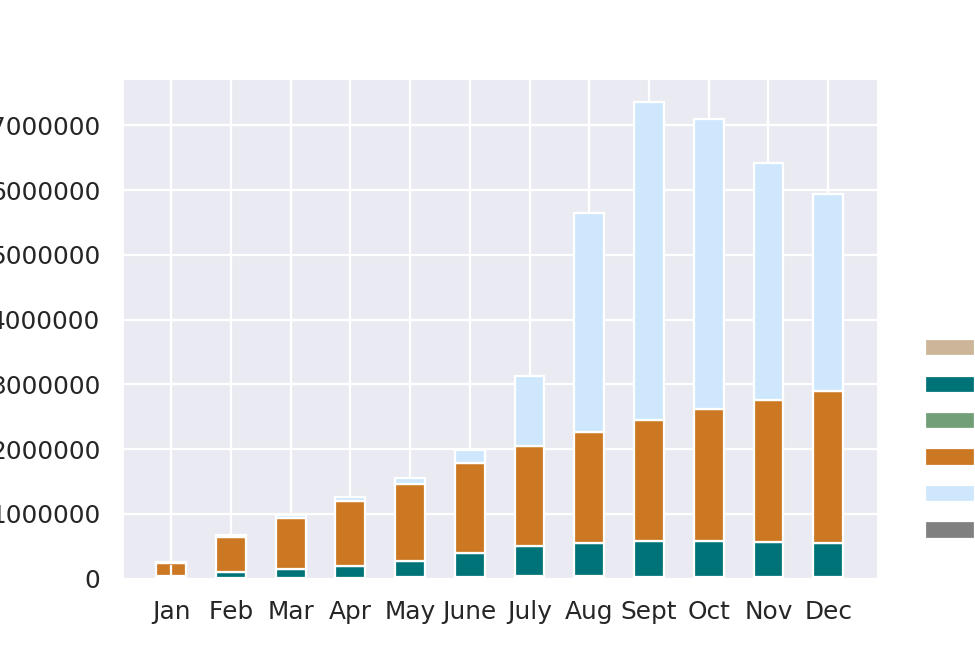

In [87]:
dust_all_p, riv_all_p, scav_all_p, sed_all_p, ice_all_p, sink_all_p = layers_positive(0,50)
plot_layer(dust_all_p, riv_all_p, scav_all_p, sed_all_p, ice_all_p, sink_all_p)

<IPython.core.display.Javascript object>


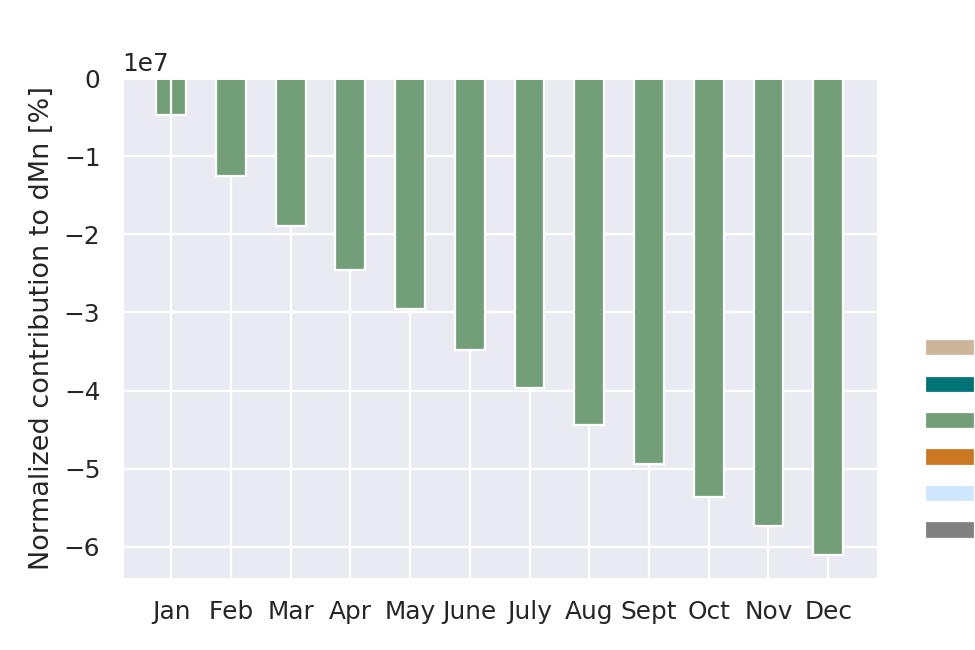

In [88]:
dust_all_n, riv_all_n, scav_all_n, sed_all_n, ice_all_n, sink_all_n = layers_negative(0,50)
plot_layer(dust_all_n, riv_all_n, scav_all_n, sed_all_n, ice_all_n, sink_all_n)

### Overview of component contributions within water masses: 

- Polar mixed layer (0-40 m)
    - PML depth levels = 1 to 17
- Pacific/halocline water (40-300 m)
    - PW depth levels = 17 to 29
- Atlantic water (300-800 m)
    - AW depth levels = 29 to 35
- Deep water (> 800 m)
    - DW depth levels = 35-50
    
Note that if a component has a negative contribution (i.e. removal), I take the absolute value of this contribution. So, what I'm really looking at is the importance of the component in the concentration/distribution of the trace metal.

In [28]:
dust_PML_p, riv_PML_p, scav_PML_p, sed_PML_p, ice_PML_p, sink_PML_p = layers_positive(0,17)
dust_PML_n, riv_PML_n, scav_PML_n, sed_PML_n, ice_PML_n, sink_PML_n = layers_negative(0,17)

In [29]:
dust_PW_p, riv_PW_p, scav_PW_p, sed_PW_p, ice_PW_p, sink_PW_p = layers_positive(17,29)
dust_PW_n, riv_PW_n, scav_PW_n, sed_PW_n, ice_PW_n, sink_PW_n = layers_negative(17,29)

In [30]:
dust_AW_p, riv_AW_p, scav_AW_p, sed_AW_p, ice_AW_p, sink_AW_p = layers_positive(29,35)
dust_AW_n, riv_AW_n, scav_AW_n, sed_AW_n, ice_AW_n, sink_AW_n = layers_negative(29,35)

In [31]:
dust_DW_p, riv_DW_p, scav_DW_p, sed_DW_p, ice_DW_p, sink_DW_p = layers_positive(35,50)
dust_DW_n, riv_DW_n, scav_DW_n, sed_DW_n, ice_DW_n, sink_DW_n = layers_negative(35,50)

### Seaborn plotting:

In [32]:
import seaborn as sns; sns.set()

Basically what I've done is I scaled the sink terms so that they sum to 100%. The scaled sink term appears to roughly balance the sources and sinks, but the non-scaled actual magnitude seems way too large... I'm confused. Is it the rate of scavenging that matters a lot more than the magnitude if there is lots of material available? 

<IPython.core.display.Javascript object>


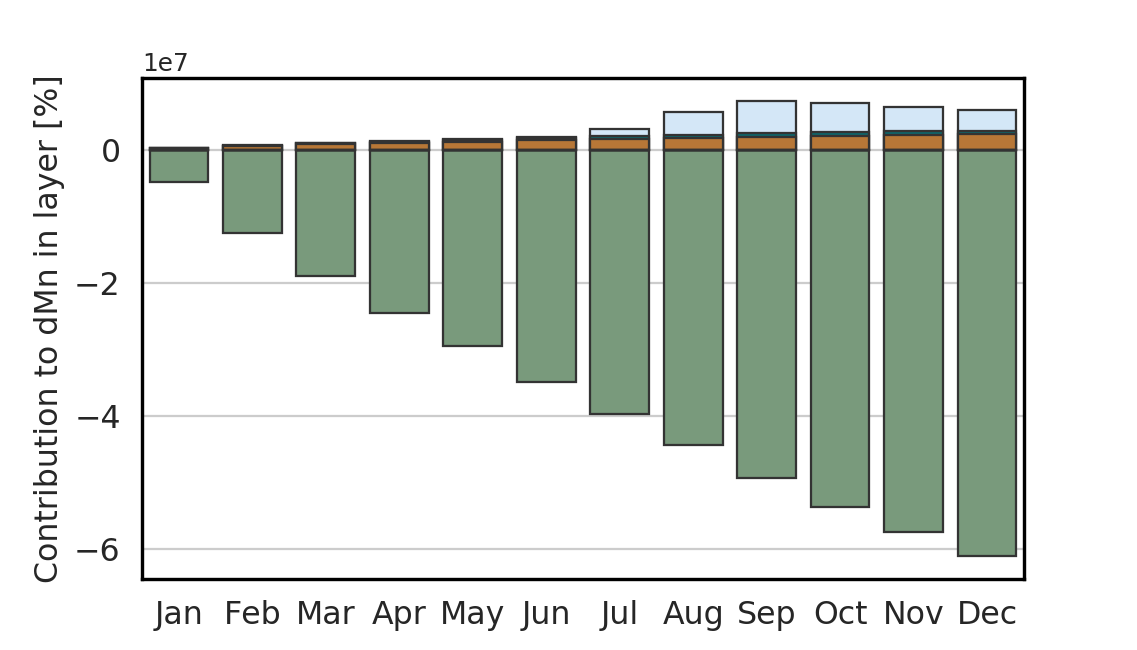

In [99]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_all_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_all_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_all_p+sed_all_p+dust_all_p+ice_all_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_all_n+sed_all_n+dust_all_n+ice_all_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_all_p+dust_all_p+riv_all_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_all_n+dust_all_n+riv_all_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_all_p+sed_all_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_all_n+sed_all_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_all_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_all_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Contribution to dMn in layer [%]', fontsize=14)
#     icp.set(ylim=(-100.0,25.0), yticks=[-20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-all_tot.png', bbox_inches='tight',dpi=300)

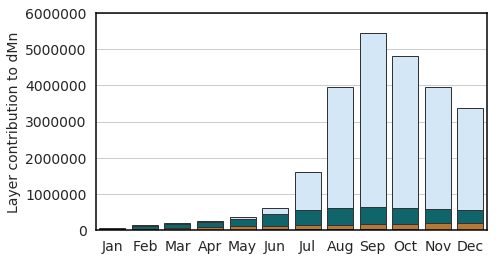

In [33]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PML_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PML_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PML_p+sed_PML_p+dust_PML_p+ice_PML_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PML_n+sed_PML_n+dust_PML_n+ice_PML_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PML_p+dust_PML_p+riv_PML_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PML_n+dust_PML_n+riv_PML_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_p+sed_PML_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_n+sed_PML_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Layer contribution to dMn', fontsize=14)
    icp.set(ylim=(0,0.6e7))
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    
#     icp.get_yaxis().get_major_formatter().set_scientific(True)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PML_src.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


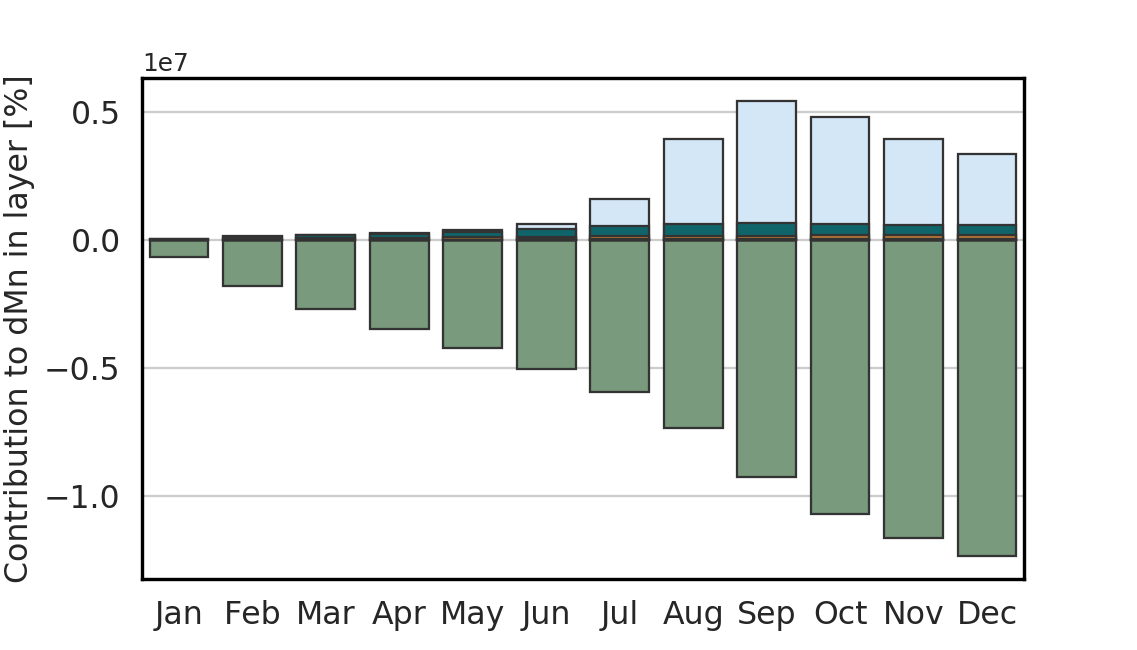

In [101]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PML_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PML_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PML_p+sed_PML_p+dust_PML_p+ice_PML_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PML_n+sed_PML_n+dust_PML_n+ice_PML_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PML_p+dust_PML_p+riv_PML_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PML_n+dust_PML_n+riv_PML_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_p+sed_PML_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_n+sed_PML_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PML_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Layer contribution to dMn', fontsize=14)
#     icp.set(ylim=(-25.0,25.0), yticks=[-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PML_tot.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


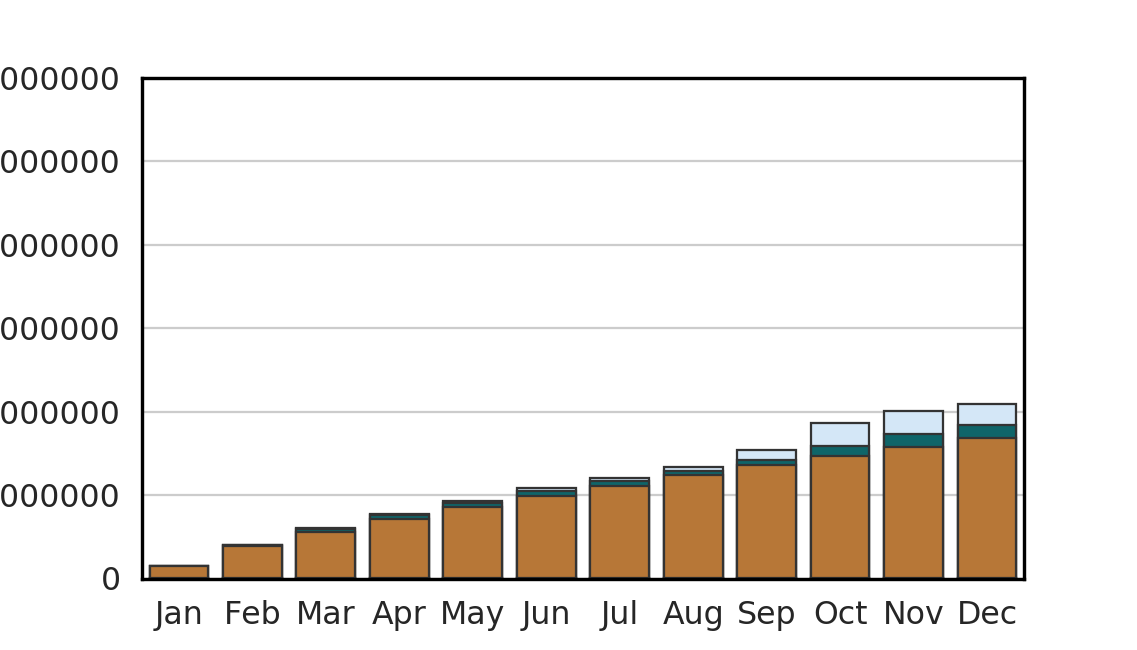

In [110]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PW_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PW_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PW_p+sed_PW_p+dust_PW_p+ice_PW_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PW_n+sed_PW_n+dust_PW_n+ice_PW_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PW_p+dust_PW_p+riv_PW_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PW_n+dust_PW_n+riv_PW_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_p+sed_PW_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_n+sed_PW_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Layer contribution to dMn', fontsize=14)
    icp.set(ylim=(0,6e6))
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PW_src.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


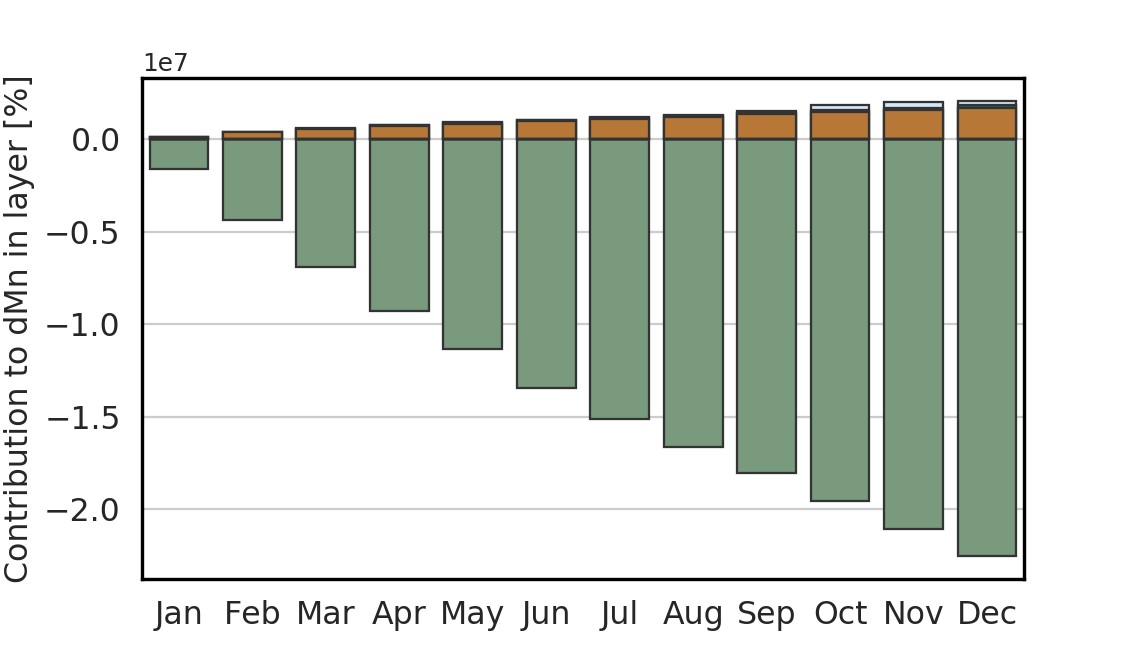

In [103]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PW_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_PW_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PW_p+sed_PW_p+dust_PW_p+ice_PW_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_PW_n+sed_PW_n+dust_PW_n+ice_PW_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PW_p+dust_PW_p+riv_PW_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_PW_n+dust_PW_n+riv_PW_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_p+sed_PW_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_n+sed_PW_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_PW_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Layer contribution to dMn', fontsize=14)
#     icp.set(ylim=(-40.0,25.0), yticks=[-40, -30, -20, -10, 0, 10, 20, 30])
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PW_tot.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


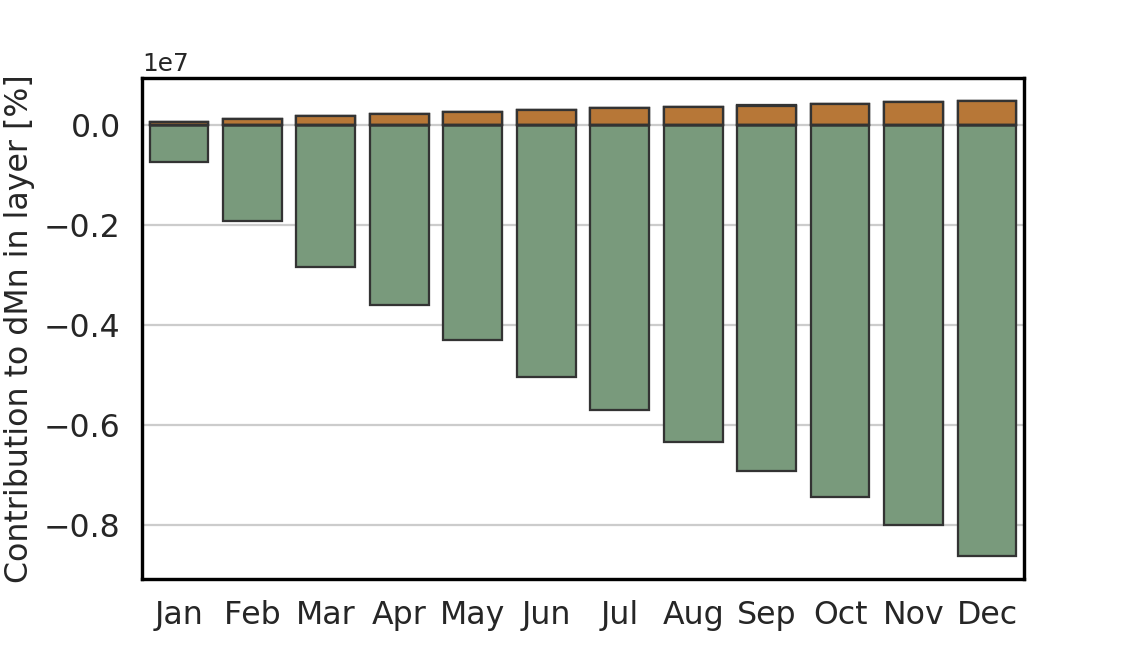

In [104]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_AW_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_AW_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_AW_p+sed_AW_p+dust_AW_p+ice_AW_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_AW_n+sed_AW_n+dust_AW_n+ice_AW_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_AW_p+dust_AW_p+riv_AW_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_AW_n+dust_AW_n+riv_AW_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_p+sed_AW_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_n+sed_AW_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Contribution to dMn in layer [%]', fontsize=14)
#     icp.set(ylim=(0,25.0))
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-AW_src.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


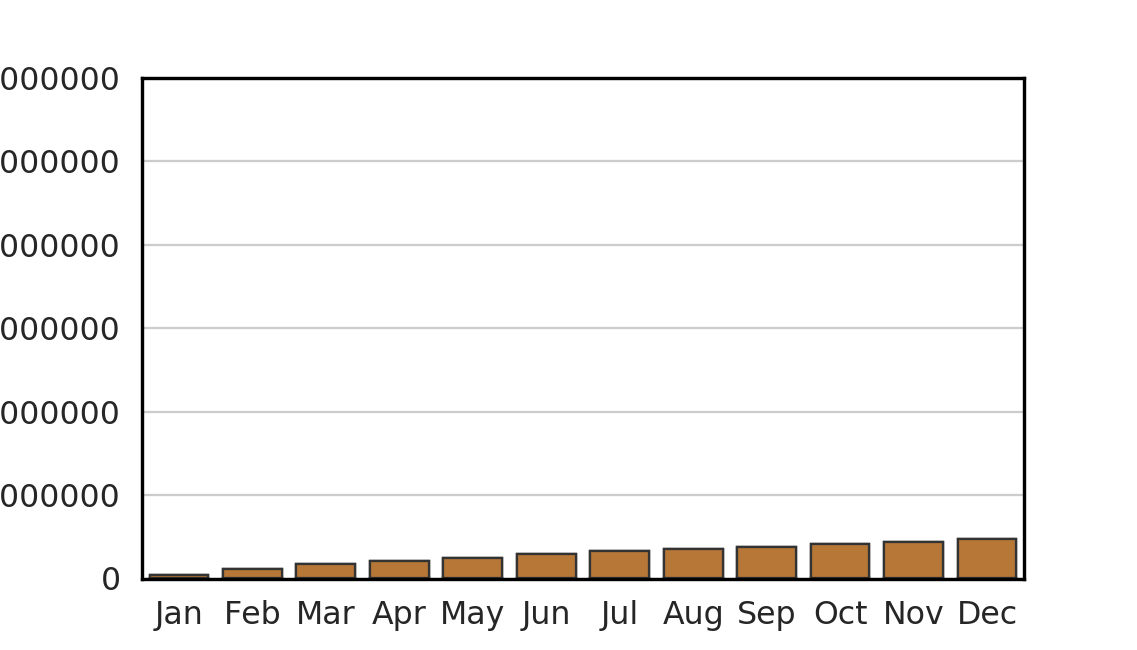

In [111]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_AW_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_AW_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_AW_p+sed_AW_p+dust_AW_p+ice_AW_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_AW_n+sed_AW_n+dust_AW_n+ice_AW_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_AW_p+dust_AW_p+riv_AW_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_AW_n+dust_AW_n+riv_AW_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_p+sed_AW_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_n+sed_AW_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_AW_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Layer contribution to dMn', fontsize=14)
    icp.set(ylim=(0,6e6))
#     icp.set(ylim=(-20.0,25.0), yticks=[-20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-AW_tot.png', bbox_inches='tight',dpi=300)

<IPython.core.display.Javascript object>


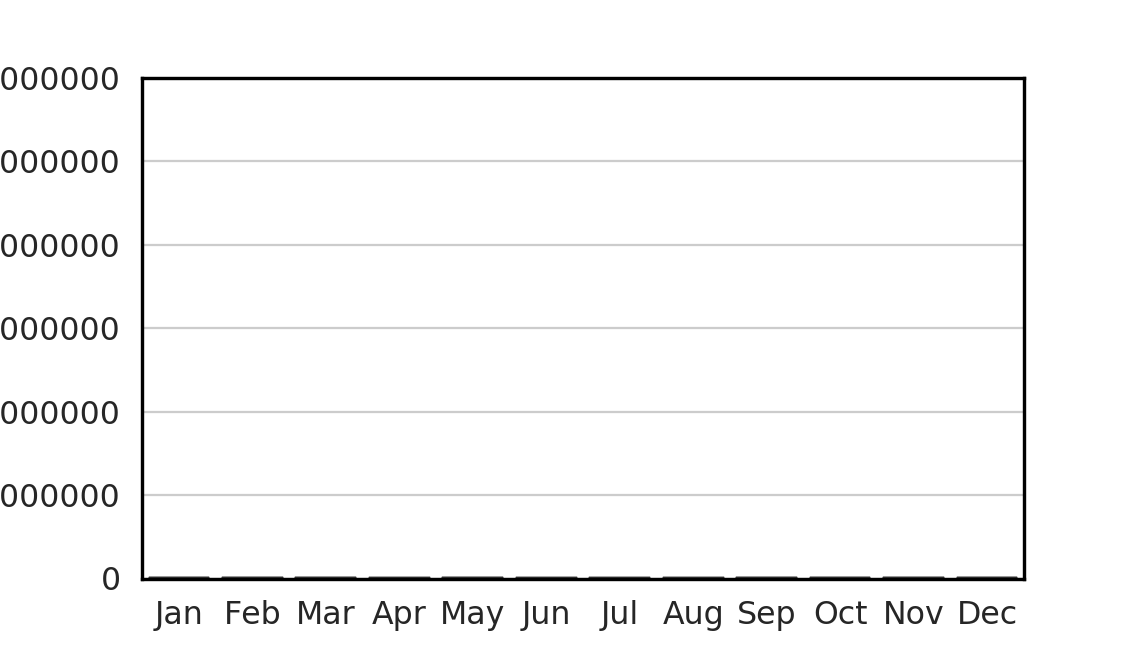

In [112]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_DW_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_DW_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_DW_p+sed_DW_p+dust_DW_p+ice_DW_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_DW_n+sed_DW_n+dust_DW_n+ice_DW_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_DW_p+dust_DW_p+riv_DW_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_DW_n+dust_DW_n+riv_DW_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_p+sed_DW_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_n+sed_DW_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_n, color=colors[0], edgecolor=".2")

    icp.set(ylim=(0,6e6))
    icp.set_ylabel('Layer contribution to dMn', fontsize=14)
#     icp.set(ylim=(0,25.0))
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-DW_src.png', bbox_inches='tight',dpi=300)

No source contributions to deep water.

<IPython.core.display.Javascript object>


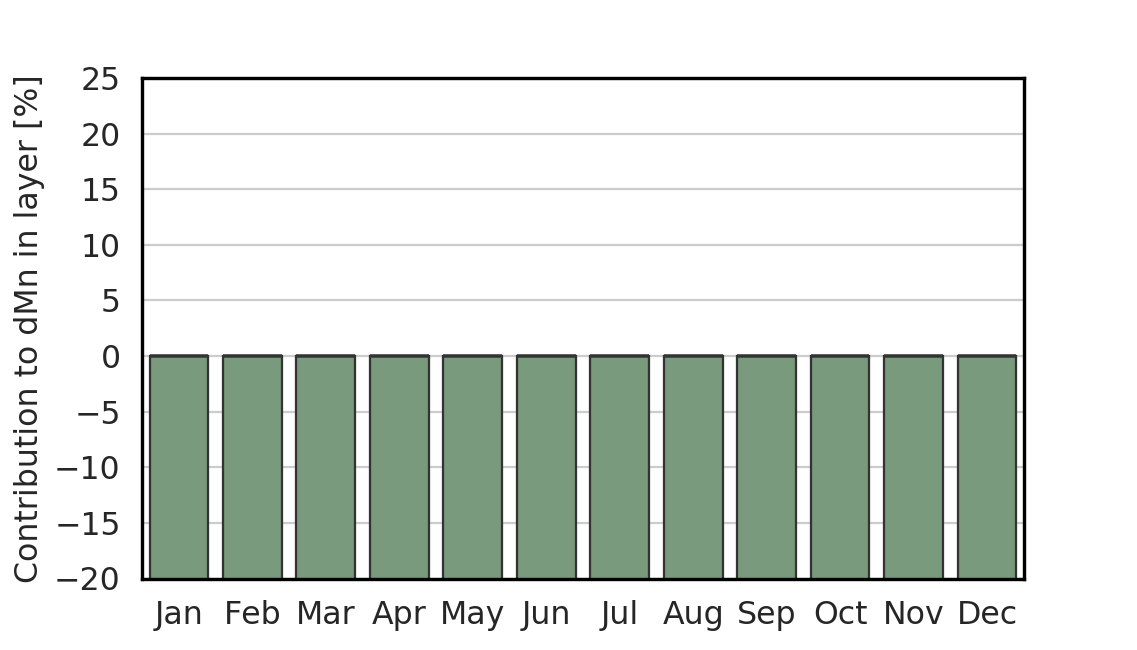

In [82]:
fig = plt.figure(figsize=(7,4))
st  = sns.axes_style("whitegrid")

with st:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_DW_p, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], scav_DW_n, color=colors[2], edgecolor=".2") 
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_DW_p+sed_DW_p+dust_DW_p+ice_DW_p, color=colors[4], edgecolor=".2")
    icn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], riv_DW_n+sed_DW_n+dust_DW_n+ice_DW_n, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_DW_p+dust_DW_p+riv_DW_p, color=colors[1], edgecolor=".2")
    rin= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], sed_DW_n+dust_DW_n+riv_DW_n, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_p+sed_DW_p, color=colors[3], edgecolor=".2")
    sen= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_n+sed_DW_n, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_p, color=colors[0], edgecolor=".2")
    dun= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', \
                     'Sep', 'Oct', 'Nov', 'Dec'], dust_DW_n, color=colors[0], edgecolor=".2")

    
    icp.set_ylabel('Contribution to dMn in layer [%]', fontsize=14)
    icp.set(ylim=(-20.0,25.0), yticks=[-20, -15, -10, -5, 0, 5, 10, 15, 20, 25])
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-DW_tot.png', bbox_inches='tight',dpi=300)

## Map of surface with the most important component

In [40]:
bottom = 0
top    = 17

dust_PML_pos   = atm_pos[:,bottom:top,:,:].sum(axis=1)
river_PML_pos  = riv_pos[:,bottom:top,:,:].sum(axis=1)
scav_PML_pos   = sca_pos[:,bottom:top,:,:].sum(axis=1)
sed_PML_pos    = sed_pos[:,bottom:top,:,:].sum(axis=1)
ice_PML_pos    = ice_pos[:,bottom:top,:,:].sum(axis=1)
sink_PML_pos   = sink_pos[:,bottom:top,:,:].sum(axis=1)   

In [41]:
def comp_importance(month, riv_prop=river_PML_pos, sed_prop=sed_PML_pos, atm_prop=dust_PML_pos, \
                    ice_prop=ice_PML_pos, scav_prop=scav_PML_pos, output=False):
    
    riv_imp = np.ma.masked_where((riv_prop[month,:,:] < sed_prop[month,:,:]), \
                             riv_prop[month,:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < atm_prop[month,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < ice_prop[month,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:]  < scav_prop[month,:,:]), riv_imp[:,:])

    sed_imp = np.ma.masked_where((sed_prop[month,:,:] < riv_prop[month,:,:]), \
                                 sed_prop[month,:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < atm_prop[month,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < ice_prop[month,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:]  < scav_prop[month,:,:]), sed_imp[:,:])


    sca_imp = np.ma.masked_where((scav_prop[month,:,:] < sed_prop[month,:,:]), \
                                 scav_prop[month,:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < atm_prop[month,:,:]), sca_imp[:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < ice_prop[month,:,:]), sca_imp[:,:])
    sca_imp = np.ma.masked_where((sca_imp[:,:]  < riv_prop[month,:,:]), sca_imp[:,:])

    ice_imp = np.ma.masked_where((ice_prop[month,:,:] < sed_prop[month,:,:]), \
                                 ice_prop[month,:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < atm_prop[month,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < riv_prop[month,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < scav_prop[month,:,:]), ice_imp[:,:])

    atm_imp = np.ma.masked_where((atm_prop[month,:,:] < sed_prop[month,:,:]), \
                                 atm_prop[month,:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < riv_prop[month,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < ice_prop[month,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < scav_prop[month,:,:]), atm_imp[:,:])

    if output:
        print('Rivers     --- Masked values before: ', np.ma.count_masked(riv_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(riv_imp[:,:]))
        print('Rivers     --- Non-masked values:    ',np.ma.count(riv_imp[:,:]))
        print('Sediment   --- Masked values before: ', np.ma.count_masked(sed_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(sed_imp[:,:]))
        print('Sediment   --- Non-masked values:    ',np.ma.count(sed_imp[:,:]))
        print('Scavenging --- Masked values before: ', np.ma.count_masked(scav_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(sca_imp[:,:]))
        print('Scavenging --- Non-masked values:    ',np.ma.count(sca_imp[:,:]))
        print('Ice        --- Masked values before: ', np.ma.count_masked(ice_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(ice_imp[:,:]))
        print('Ice        --- Non-masked values:    ',np.ma.count(ice_imp[:,:]))
        print('Dust       --- Masked values before: ', np.ma.count_masked(atm_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(atm_imp[:,:]))
        print('Dust       --- Non-masked values:    ',np.ma.count(atm_imp[:,:]))

    return riv_imp, sed_imp, sca_imp, ice_imp, atm_imp

In [42]:
month   = 8

In [43]:
riv_imp, sed_imp, sca_imp, ice_imp, atm_imp = comp_importance(month, output=True)

Rivers     --- Masked values before:  175675 , after:  351378
Rivers     --- Non-masked values:     13422
Sediment   --- Masked values before:  175675 , after:  356932
Sediment   --- Non-masked values:     7868
Scavenging --- Masked values before:  175675 , after:  356944
Scavenging --- Non-masked values:     7856
Ice        --- Masked values before:  175675 , after:  181286
Ice        --- Non-masked values:     183514
Dust       --- Masked values before:  175675 , after:  356955
Dust       --- Non-masked values:     7845


### Seasonal cycle:

In [47]:
def plot_year_importance(fig, ax, proj1):
    
    x, y = proj1(lon_model, lat_model)
    
    axes=[ax[0,0], ax[0,1], ax[0,2], ax[0,3], \
          ax[1,0], ax[1,1], ax[1,2], ax[1,3], \
          ax[2,0], ax[2,1], ax[2,2], ax[2,3]]
    
    for month in range(0,12):
        riv_imp, sed_imp, sca_imp, ice_imp, atm_imp = comp_importance(month)
    
        proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'.', markersize=0.03,c=colors[0], ax=axes[month])
        proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'.', markersize=0.03, c=colors[1], ax=axes[month])
        proj1.plot(x[~sca_imp.mask], y[~sca_imp.mask],'.', markersize=0.03, c=colors[2], ax=axes[month])
        proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'.', markersize=0.03, c=colors[3], ax=axes[month])
        proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'.', markersize=0.03, c=colors[4], ax=axes[month])
        
        proj1.contourf(x, y, land_mask[17, 1480:2050, 160:800], vmax=0.3, \
                       cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)
        axes[month].set_title(months[month])
    
    return

<IPython.core.display.Javascript object>


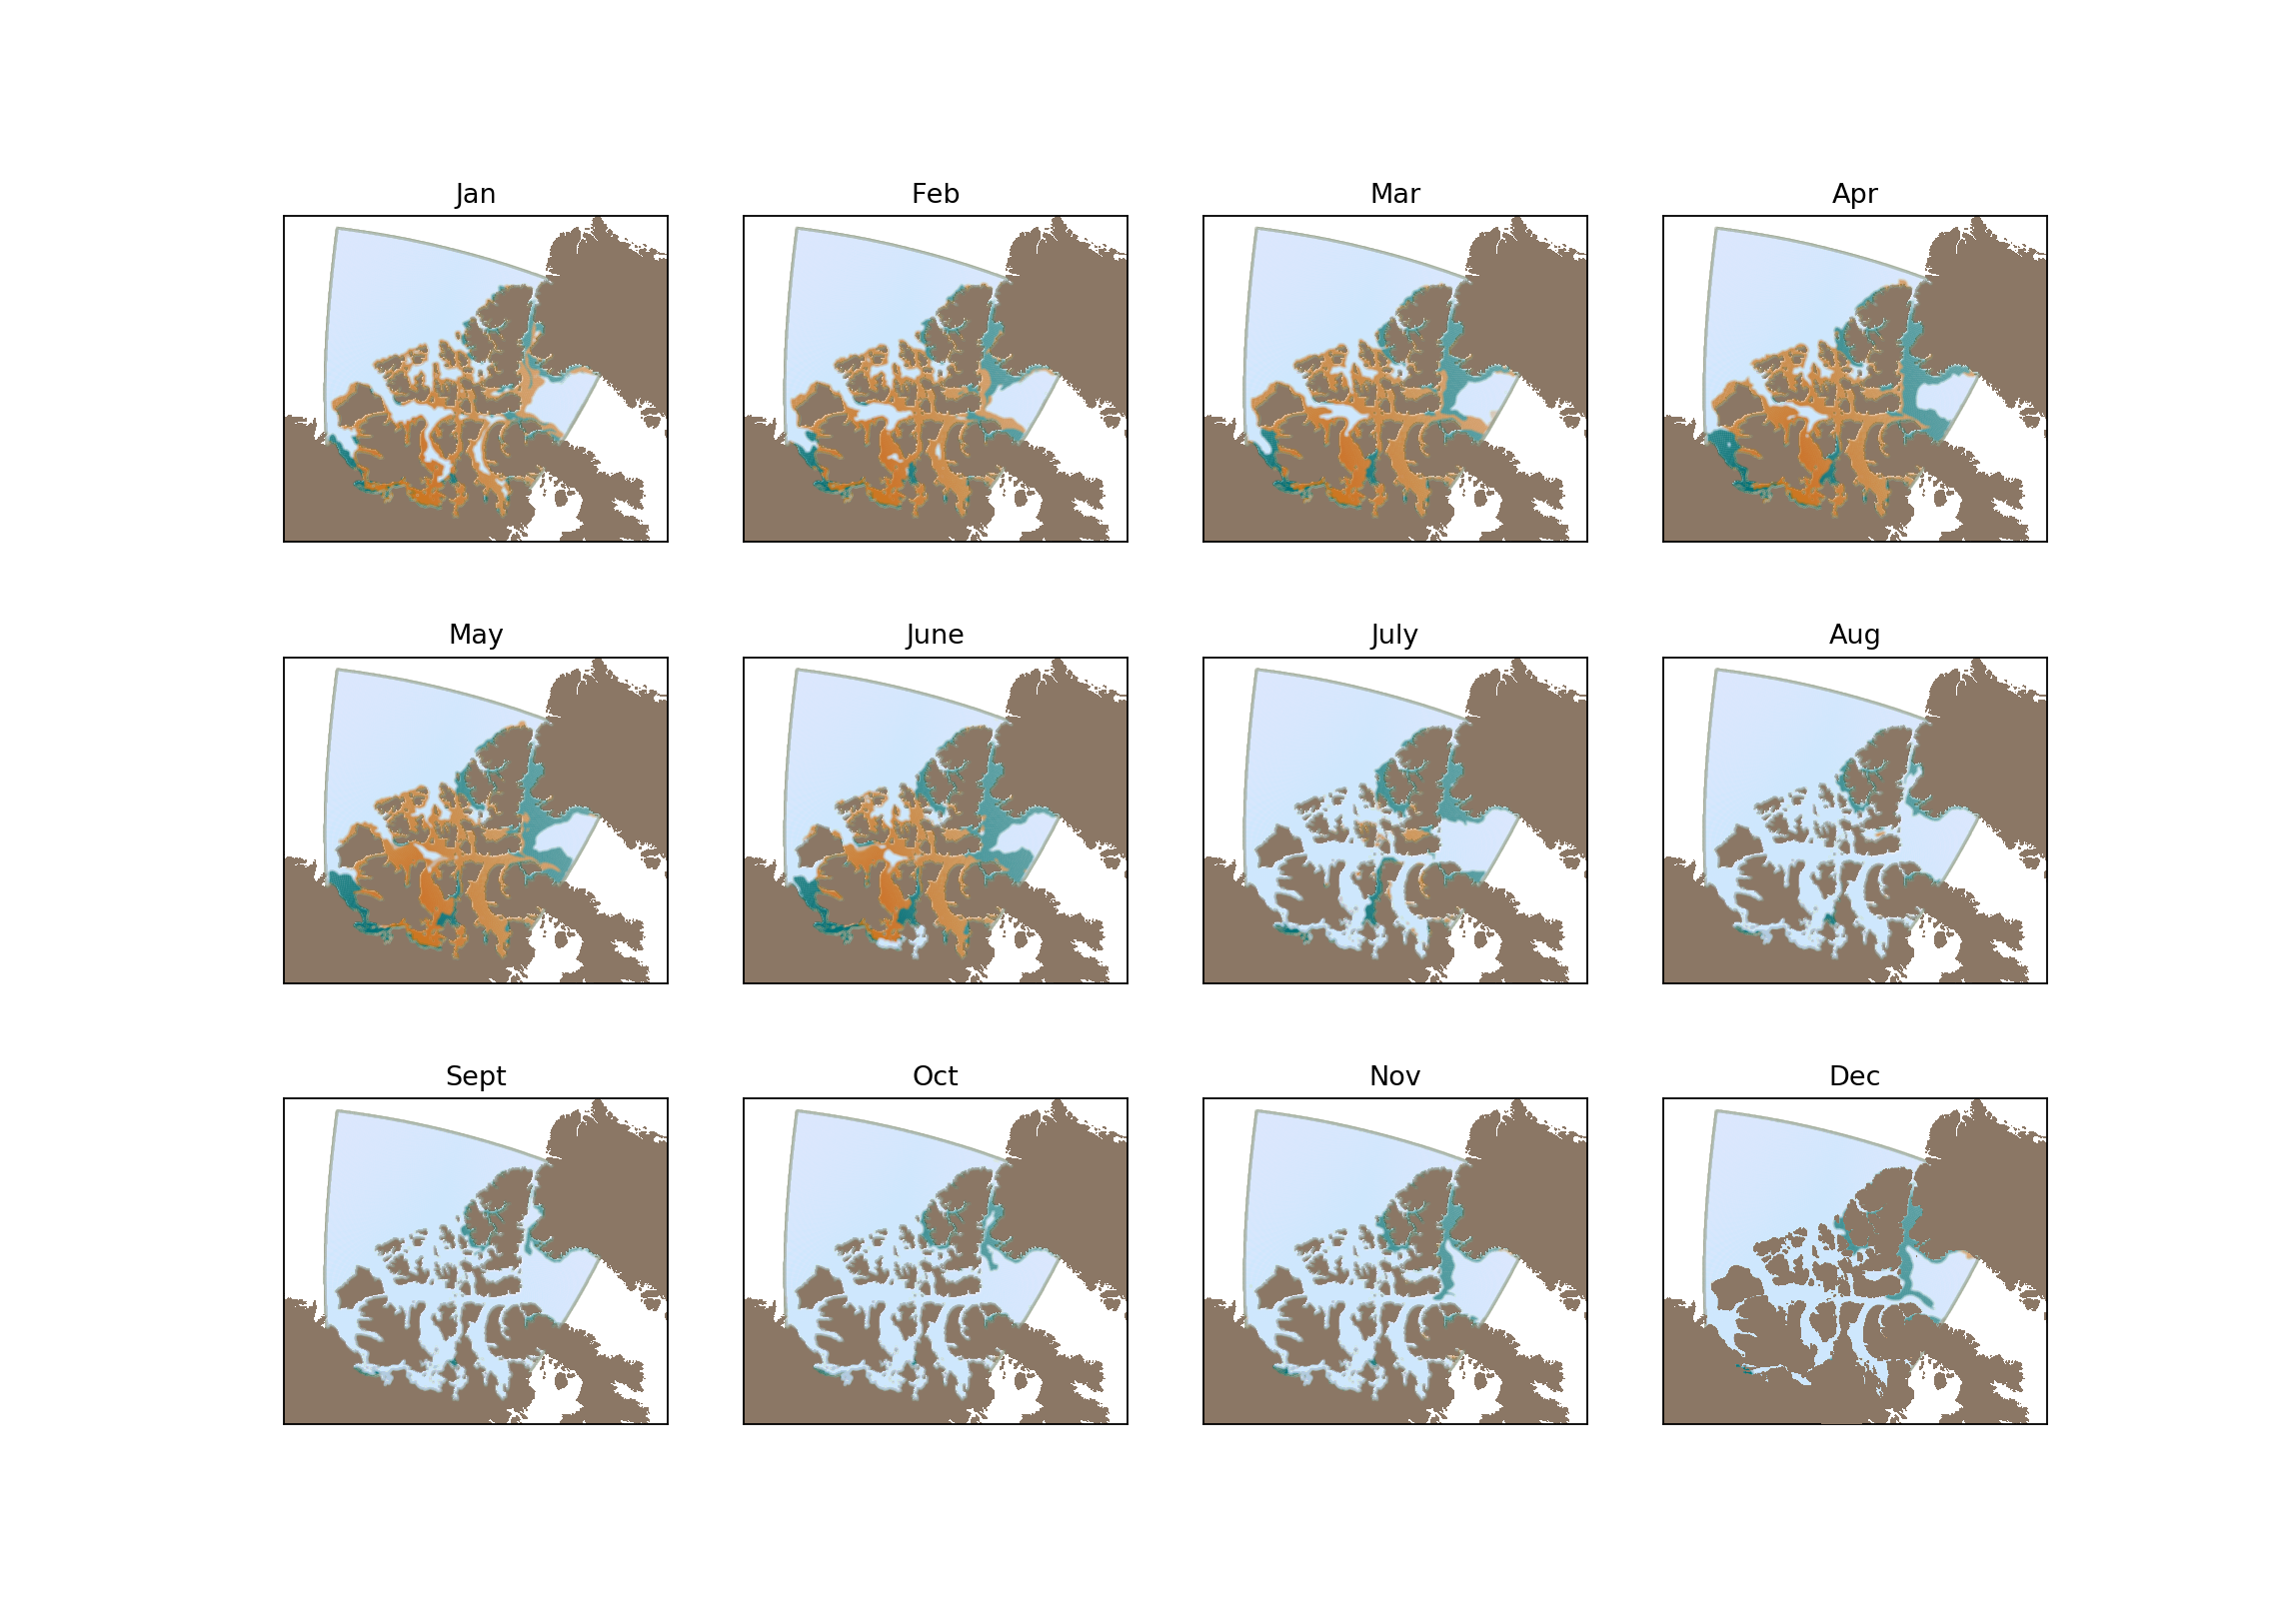

No handles with labels found to put in legend.


In [50]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/analysis-brogalla/maps/surface-Mn_subplots.pickle','rb'))

plot_year_importance(fig, ax, proj1)

# proj1.plot(0,0,'.', markersize=20, c=colors[0], label='Dust from atmosphere')
# proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
# proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
# proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
# proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/seasonal-components.png', bbox_inches='tight', dpi=300)